In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

cur_dir = os.getcwd()
train_set = pd.read_csv(cur_dir + '/../data/train_set_artificial.csv', low_memory=False)
test_set = pd.read_csv(cur_dir + '/../data/test_set.csv', low_memory=False)
val_set = pd.read_csv(cur_dir + '/../data/validation_set.csv', low_memory=False)

#Add validation set to test set, since we wound up using cross validation
test_set = pd.concat([test_set, val_set], axis=0)

df = pd.concat([train_set, test_set, val_set], axis=0)

X_train = train_set.drop(['delay_class'],axis=1)
y_train = train_set['delay_class']

X_test = test_set.drop(['delay_class'],axis=1)
y_test = test_set['delay_class']

In [2]:
df

,carrier,origin,dest,air_time,distance,Maximum,Minimum,Average,Departure,Precipitation,New Snow,Snow Depth,days_in_365,sched_time_in_min,Precipitation Binary,New Snow Binary,Snow Depth Binary,delay_class
0,DL,JFK,MCO,0.170370,0.176219,0.358025,0.346667,0.350649,0.418301,0.000000,0.0,0.0,0.917582,0.316067,yes,no,no,no
1,EV,EWR,MCI,0.229630,0.206404,0.407407,0.333333,0.370130,0.254902,0.000000,0.0,0.0,0.840659,0.374012,yes,no,no,no
2,B6,JFK,MSY,0.232593,0.224760,0.308642,0.293333,0.298701,0.241830,0.000000,0.0,0.0,0.250000,0.087796,no,no,no,no
3,B6,EWR,FLL,0.195556,0.200897,0.506173,0.493333,0.500000,0.459695,0.000000,0.0,0.0,0.274725,0.579456,yes,no,no,yes
4,WN,LGA,BNA,0.130370,0.139506,0.691358,0.773333,0.733766,0.250545,0.004988,0.0,0.0,0.530220,0.267779,yes,no,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65464,UA,EWR,SJU,0.266667,0.311646,0.740741,0.640000,0.694805,0.246187,0.000000,0.0,0.0,0.623626,0.210711,no,no,no,yes
65465,EV,EWR,ATL,0.130370,0.135835,0.259259,0.266667,0.259740,0.344227,0.000000,0.0,0.0,0.164835,0.611062,yes,yes,no,no
65466,UA,EWR,SFO,0.441481,0.506833,0.814815,0.826667,0.824675,0.457516,0.000000,0.0,0.0,0.494505,0.759438,yes,no,no,yes
65467,DL,LGA,PBI,0.198519,0.194779,0.407407,0.306667,0.357143,0.267974,0.000000,0.0,0.0,0.870879,0.373134,no,no,no,no


In [3]:
from sklearn.preprocessing import OneHotEncoder

# Transform categorical features into binary features
categorical_columns = list(X_train.select_dtypes(include=['object']).columns)
encoder = OneHotEncoder()

# Use df to fit the encoder to prevent scenarios that the binary features in train and test sets are different, 
# For example, test set has dest_LAX, but train set does not have dest_LAX
encoder.fit(df[categorical_columns])

X_train_category = encoder.transform(X_train[categorical_columns])
X_test_category = encoder.transform(X_test[categorical_columns])

# Get numerical features
numerical_columns = list(X_train.select_dtypes(include=['float64']).columns)

# Combine the numerical and categorical features
X_train_df_category = pd.DataFrame(X_train_category.toarray())
X_train_df_category.columns = encoder.get_feature_names_out()
X_train_df_numerical = pd.DataFrame(X_train[numerical_columns]).reset_index(drop=True)
X_train_encoded = pd.concat([X_train_df_numerical, X_train_df_category], axis=1)


X_test_df_category = pd.DataFrame(X_test_category.toarray())
X_test_df_category.columns = encoder.get_feature_names_out()
X_test_df_numerical = pd.DataFrame(X_test[numerical_columns]).reset_index(drop=True)
X_test_encoded = pd.concat([X_test_df_numerical, X_test_df_category], axis=1)

# Drop encoded columns that have very few positive values, in order to reduce our dimensionality.
# These columns were identified in "DropOneHotEncodingColumn.ipynb"
columns_to_drop = ['dest_CHO', 'dest_BUF', 'dest_CAE', 'dest_CHS', 'dest_BUR', 'dest_BQN', 'dest_BGR', 'dest_SNA', 'dest_IND', 'dest_ABQ', 'dest_BWI', 'dest_OAK', 'dest_SAN', 'dest_SDF', 'dest_HNL', 'dest_GSP', 'dest_TUL', 'dest_TYS', 'dest_RSW', 'New Snow Binary_no','dest_SBN', 'dest_OMA', 'dest_GRR', 'dest_BDL', 'dest_MKE', 'dest_PWM', 'dest_DSM', 'dest_JAX', 'dest_HDN','dest_STL','Precipitation Binary_no','dest_EYW','dest_EGE','dest_PVD','dest_PSE','dest_PDX','dest_MTJ','dest_MEM','dest_JAC','dest_SAV','dest_SLC','dest_CAK','dest_RIC','dest_MVY','dest_LEX','dest_DAY','dest_PIT','dest_CRW','dest_BZN','dest_ORF','dest_BTV','dest_XNA','dest_IAD','dest_GSO','dest_MHT','dest_SEA','dest_SRQ','dest_PSP','dest_ANC','dest_CVG','dest_STT','dest_MYR','dest_SJC','dest_MDW','dest_AUS','dest_ACK','dest_CMH','dest_PHL','dest_MSN','dest_SMF','dest_CLE','dest_PHX','dest_AVL','dest_ALB','dest_ILM','dest_ROC','Snow Depth Binary_no','dest_MCI','dest_HOU','dest_LAS','dest_OKC','dest_SAT','dest_TVC','dest_SYR','dest_BHM','dest_LGB','dest_MSY']

X_train_encoded.drop(columns_to_drop, axis=1, inplace=True)
X_test_encoded.drop(columns_to_drop, axis=1, inplace=True)

In [4]:
X_train_encoded

,air_time,distance,Maximum,Minimum,Average,Departure,Precipitation,New Snow,Snow Depth,days_in_365,...,dest_MSP,dest_ORD,dest_PBI,dest_RDU,dest_SFO,dest_SJU,dest_TPA,Precipitation Binary_yes,New Snow Binary_yes,Snow Depth Binary_yes
0,0.170370,0.176219,0.358025,0.346667,0.350649,0.418301,0.000000,0.0,0.0,0.917582,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.229630,0.206404,0.407407,0.333333,0.370130,0.254902,0.000000,0.0,0.0,0.840659,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.232593,0.224760,0.308642,0.293333,0.298701,0.241830,0.000000,0.0,0.0,0.250000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.195556,0.200897,0.506173,0.493333,0.500000,0.459695,0.000000,0.0,0.0,0.274725,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.130370,0.139506,0.691358,0.773333,0.733766,0.250545,0.004988,0.0,0.0,0.530220,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293895,0.432344,0.483009,0.716049,0.666667,0.694805,0.405229,0.000000,0.0,0.0,0.445055,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
293896,0.119368,0.122401,0.740741,0.680000,0.714286,0.601307,0.000000,0.0,0.0,0.758242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
293897,0.182222,0.207220,0.595520,0.589003,0.593587,0.350269,0.002057,0.0,0.0,0.372975,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
293898,0.048651,0.045074,0.738151,0.736785,0.740578,0.395707,0.018992,0.0,0.0,0.480462,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [5]:
X_test_encoded

,air_time,distance,Maximum,Minimum,Average,Departure,Precipitation,New Snow,Snow Depth,days_in_365,...,dest_MSP,dest_ORD,dest_PBI,dest_RDU,dest_SFO,dest_SJU,dest_TPA,Precipitation Binary_yes,New Snow Binary_yes,Snow Depth Binary_yes
0,0.305185,0.267387,0.444444,0.253333,0.350649,0.627451,0.112219,0.0,0.0,0.082418,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.407407,0.488476,0.827160,0.840000,0.837662,0.501089,0.000000,0.0,0.0,0.516484,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.405926,0.437895,0.296296,0.253333,0.272727,0.294118,0.000000,0.0,0.0,0.197802,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.183704,0.139099,0.790123,0.813333,0.805195,0.385621,0.000000,0.0,0.0,0.607143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.171852,0.133184,0.345679,0.266667,0.305195,0.405229,0.000000,0.0,0.1,0.967033,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130934,0.266667,0.311646,0.740741,0.640000,0.694805,0.246187,0.000000,0.0,0.0,0.623626,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
130935,0.130370,0.135835,0.259259,0.266667,0.259740,0.344227,0.000000,0.0,0.0,0.164835,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
130936,0.441481,0.506833,0.814815,0.826667,0.824675,0.457516,0.000000,0.0,0.0,0.494505,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
130937,0.198519,0.194779,0.407407,0.306667,0.357143,0.267974,0.000000,0.0,0.0,0.870879,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

decision_tree = DecisionTreeClassifier()
param_grid = {
    'criterion': ["gini", "entropy", "log_loss"],
    'max_depth': [15, 20, 25],
    'min_samples_leaf': [70, 85, 100],
    'ccp_alpha': [0, 0.05, 0.1]
}
print("Performing grid search...")
grid_search = GridSearchCV(decision_tree, param_grid=param_grid, cv=4, verbose=2)
grid_search.fit(X_train_encoded, y_train)
print("Grid Search complete!")
print("Best Hyperparameters:", grid_search.best_params_)

tuned_tree = DecisionTreeClassifier(criterion=grid_search.best_params_['criterion'],
                                    max_depth=grid_search.best_params_['max_depth'],
                                    min_samples_leaf=grid_search.best_params_['min_samples_leaf'])
tuned_tree.fit(X_train_encoded, y_train)
accuracy = tuned_tree.score(X_test_encoded, y_test)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Performing grid search...
Fitting 4 folds for each of 81 candidates, totalling 324 fits
[CV] END ccp_alpha=0, criterion=gini, max_depth=15, min_samples_leaf=70; total time=   2.4s
[CV] END ccp_alpha=0, criterion=gini, max_depth=15, min_samples_leaf=70; total time=   2.2s
[CV] END ccp_alpha=0, criterion=gini, max_depth=15, min_samples_leaf=70; total time=   2.1s
[CV] END ccp_alpha=0, criterion=gini, max_depth=15, min_samples_leaf=70; total time=   2.1s
[CV] END ccp_alpha=0, criterion=gini, max_depth=15, min_samples_leaf=85; total time=   2.3s
[CV] END ccp_alpha=0, criterion=gini, max_depth=15, min_samples_leaf=85; total time=   2.2s
[CV] END ccp_alpha=0, criterion=gini, max_depth=15, min_samples_leaf=85; total time=   2.1s
[CV] END ccp_alpha=0, criterion=gini, max_depth=15, min_samples_leaf=85; total time=   2.1s
[CV] END ccp_alpha=0, criterion=gini, max_depth=15, min_samples_leaf=100; total time=   2.2s
[CV] END ccp_alpha=0, criterion=gini, max_depth=15, min_samples_leaf=100; total tim

[CV] END ccp_alpha=0, criterion=log_loss, max_depth=20, min_samples_leaf=70; total time=   2.4s
[CV] END ccp_alpha=0, criterion=log_loss, max_depth=20, min_samples_leaf=85; total time=   2.7s
[CV] END ccp_alpha=0, criterion=log_loss, max_depth=20, min_samples_leaf=85; total time=   2.5s
[CV] END ccp_alpha=0, criterion=log_loss, max_depth=20, min_samples_leaf=85; total time=   2.4s
[CV] END ccp_alpha=0, criterion=log_loss, max_depth=20, min_samples_leaf=85; total time=   2.4s
[CV] END ccp_alpha=0, criterion=log_loss, max_depth=20, min_samples_leaf=100; total time=   2.7s
[CV] END ccp_alpha=0, criterion=log_loss, max_depth=20, min_samples_leaf=100; total time=   2.5s
[CV] END ccp_alpha=0, criterion=log_loss, max_depth=20, min_samples_leaf=100; total time=   2.3s
[CV] END ccp_alpha=0, criterion=log_loss, max_depth=20, min_samples_leaf=100; total time=   2.3s
[CV] END ccp_alpha=0, criterion=log_loss, max_depth=25, min_samples_leaf=70; total time=   2.8s
[CV] END ccp_alpha=0, criterion=log_

[CV] END ccp_alpha=0.05, criterion=entropy, max_depth=25, min_samples_leaf=85; total time=   2.9s
[CV] END ccp_alpha=0.05, criterion=entropy, max_depth=25, min_samples_leaf=85; total time=   2.5s
[CV] END ccp_alpha=0.05, criterion=entropy, max_depth=25, min_samples_leaf=85; total time=   2.4s
[CV] END ccp_alpha=0.05, criterion=entropy, max_depth=25, min_samples_leaf=85; total time=   2.4s
[CV] END ccp_alpha=0.05, criterion=entropy, max_depth=25, min_samples_leaf=100; total time=   2.8s
[CV] END ccp_alpha=0.05, criterion=entropy, max_depth=25, min_samples_leaf=100; total time=   2.5s
[CV] END ccp_alpha=0.05, criterion=entropy, max_depth=25, min_samples_leaf=100; total time=   2.4s
[CV] END ccp_alpha=0.05, criterion=entropy, max_depth=25, min_samples_leaf=100; total time=   2.4s
[CV] END ccp_alpha=0.05, criterion=log_loss, max_depth=15, min_samples_leaf=70; total time=   2.6s
[CV] END ccp_alpha=0.05, criterion=log_loss, max_depth=15, min_samples_leaf=70; total time=   2.4s
[CV] END ccp_a

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=15, min_samples_leaf=85; total time=   2.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=15, min_samples_leaf=85; total time=   2.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=15, min_samples_leaf=85; total time=   2.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=15, min_samples_leaf=100; total time=   2.5s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=15, min_samples_leaf=100; total time=   2.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=15, min_samples_leaf=100; total time=   2.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=15, min_samples_leaf=100; total time=   2.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=20, min_samples_leaf=70; total time=   2.8s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=20, min_samples_leaf=70; total time=   2.6s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=20, min_samples_leaf=70; total time=   2.4s
[CV] END ccp_alpha=0.1, cr

In [7]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

y_pred = tuned_tree.predict(X_test_encoded)
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

print(classification_report(y_test, y_pred))

[[74213 23882]
 [13605 19239]]
              precision    recall  f1-score   support

          no       0.85      0.76      0.80     98095
         yes       0.45      0.59      0.51     32844

    accuracy                           0.71    130939
   macro avg       0.65      0.67      0.65    130939
weighted avg       0.75      0.71      0.73    130939



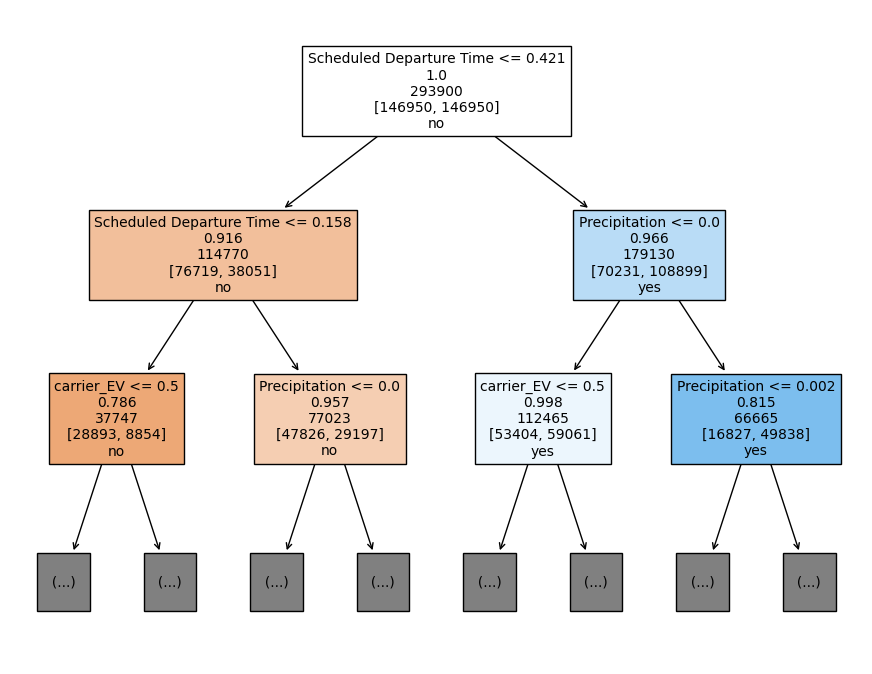

In [10]:
from sklearn import tree

names = X_train_encoded.columns.values
names = list(map(lambda x: x.replace('sched_time_in_min','Scheduled Departure Time'),names))

fig = plt.figure(figsize = (11, 8.5))
_ = tree.plot_tree(tuned_tree, 
                   feature_names=names,  
                   class_names=y_train.unique(),
                   filled=True, max_depth=2, fontsize=10, label='none')
fig.savefig("decision_tree.pdf")